# Встановлення залежностей

In [2]:
!pip install wfdb
!pip install py-ecg-detectors
!pip install sklearn
!pip install gensim
!pip install -U scikit-learn

In [3]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from ecgdetectors import Detectors

# Завантаження даних ЕКГ

In [4]:
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

You already have the data.


In [5]:
record = record = wfdb.rdsamp('mitdb/100', sampto=500000)
record[1]
# record[0][:,0]
#annotation = wfdb.rdann('mitdb/100','atr', sampfrom=50)
# record[1]
# record[0][:,0]
#sample = annotation.__dict__
#sample

{'fs': 360,
 'sig_len': 500000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

# Виділення R піків

In [6]:
fs = 250
detectors = Detectors(fs)
unfiltered_ecg = record[0][:, 1]
r_peaks = detectors.engzee_detector(unfiltered_ecg)
# Amendment for first peak
r_peaks[0] += 20

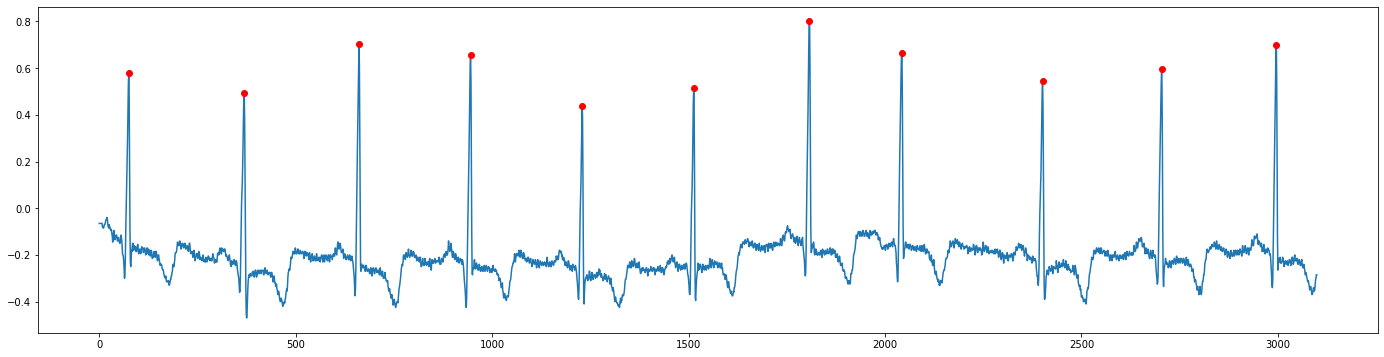

In [7]:
r_peaks_split = r_peaks[:11]
plt.figure(figsize=(24,6))
plt.plot(unfiltered_ecg[:3100])
plt.plot(r_peaks_split, unfiltered_ecg[r_peaks_split], 'ro')
plt.show()

# Розподіл ЕКГ сигналу на серцебиття

In [8]:
# Find heartbeat lenght
distances = []
for i in range(len(r_peaks)):
    if i + 1 < len(r_peaks):
        distances.append(r_peaks[i + 1] - r_peaks[i])
distances = np.array(distances)
heart_beat_len = int(distances.mean())
heart_beat_len

286

In [9]:
# Beat EGC signal
beats = []
for i in range(len(r_peaks)):
    if i != 0 :
        r_index = r_peaks[i]
        retreat = heart_beat_len // 2
        beats.append(unfiltered_ecg[r_index - retreat:r_index + retreat])

In [10]:
p_waves = []
qrs_waves = []
t_waves = []
for j in range(len(beats)):
    if j + 1 != len(beats):
        p_waves.append(beats[j][:retreat - 15])
        qrs_waves.append(beats[j][retreat - 15:retreat + 15])
        t_waves.append(beats[j][retreat + 15:])

print(len(t_waves[0]))
print(len(p_waves))

128
1742


In [43]:

# Returns (p_waves, qrs_waves, t_waves)
def split_waves(beats_list, retreat_value):
    c_p_waves = []
    c_qrs_waves = []
    c_t_waves = []
    for j in range(len(beats_list) - 1):
            c_p_waves.append(beats_list[j][:retreat_value - 15])
            c_qrs_waves.append(beats_list[j][retreat_value - 15:retreat_value + 15])
            c_t_waves.append(beats_list[j][retreat_value + 15:])
    return c_p_waves, c_qrs_waves, c_t_waves

# Returns (kmeans, predicted)
def calculate_kmeans(waves, n_clusters, n_init):
    c_kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init)
    c_kmeans.fit(waves)
    c_predicted = c_kmeans.predict(waves)
    return c_kmeans, c_predicted

# Returns list original values (values of cluster centers)
# predicted - list of clusters indices
def reverse_kmeans(predicted, c_kmeans):
    cluster_centers = c_kmeans.cluster_centers_
    def get_mean_of_cluster(x):
        return cluster_centers[x]

    reverse_func = np.vectorize(get_mean_of_cluster, signature='()->(n)')
    return reverse_func(predicted)

def draw_two_waves(wave1, wave2, img_name):
    plt.figure(figsize=(24,6))
    plt.plot(wave1)
    plt.plot(wave2)
    plt.savefig(img_name, transparent=False)

def calculate_mse_percent(beats_list, retreat_value, peaks_clusters_count, pt_clusters_count):
    (c_p_waves, c_qrs_waves, c_t_waves) = split_waves(beats_list, retreat_value)
    qrs_kmeans, qrs_predicted = calculate_kmeans(c_qrs_waves, peaks_clusters_count, peaks_clusters_count // 2)
    c_pt_waves = np.array(c_p_waves + c_t_waves)
    pt_kmeans, pt_predicted = calculate_kmeans(c_pt_waves, pt_clusters_count, pt_clusters_count // 2)

    restored_qrs_original = reverse_kmeans(qrs_predicted, qrs_kmeans)
    restored_pt_original = reverse_kmeans(pt_predicted, pt_kmeans)

    split = np.split(restored_pt_original, 2)
    restored_t_original = split[0]
    restored_p_original = split[1]
    print("TShape: " + str(restored_t_original.shape))
    print("PShape: " + str(restored_p_original.shape))
    print("QRSShape: " + str(restored_qrs_original.shape))

    restored_original_beats = np.concatenate((restored_t_original, restored_qrs_original, restored_p_original), axis=1)

    restored_concatenated_beats = np.concatenate(restored_original_beats)[:3100]
    original_concatenated_beats = np.concatenate(beats_list)[:3100]
    draw_two_waves(restored_concatenated_beats, original_concatenated_beats, "test_"+str(peaks_clusters_count)+"peaksClusters_" + str(pt_clusters_count) + "ptClusters.jpg")
    return np.sqrt(np.mean(np.square(((original_concatenated_beats - restored_concatenated_beats) / original_concatenated_beats)), axis=0))

In [46]:
def start_test():
    start_params = [6, 20]

    scaling = np.arange(1, 11)
    params = []
    result_mse = []
    for cur_scaling in scaling:
        cur_params = [start_params[0] * cur_scaling, start_params[1] * cur_scaling]
        params.append(cur_params)
        mse = calculate_mse_percent(beats, retreat, cur_params[0], cur_params[1])
        result_mse.append(mse)

    summed_params = []
    for param in params:
        summed_params.append(param[0] + param[1])

    print(summed_params)
    plt.figure(figsize=(24,6))
    plt.plot(summed_params, result_mse)
    plt.scatter(summed_params, result_mse, marker='v', color='r')
    plt.savefig("mse_graph.jpg")
    plt.show()


TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
TShape: (1742, 128)
PShape: (1742, 128)
QRSShape: (1742, 30)
[26, 52, 78, 104, 130, 156, 182, 208, 234, 260]


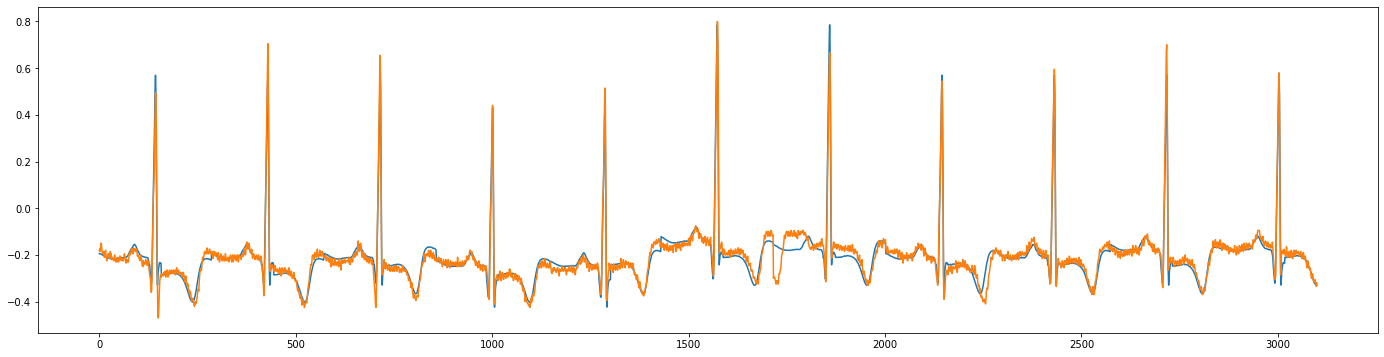

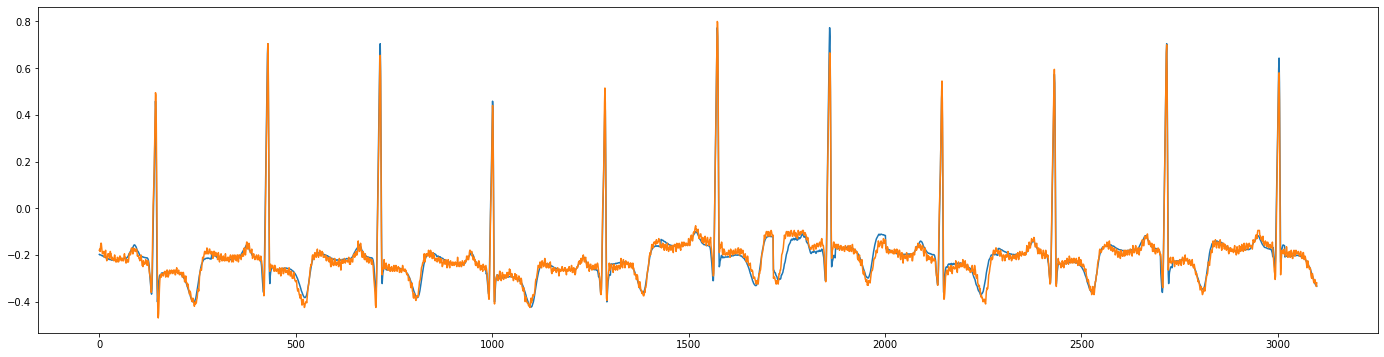

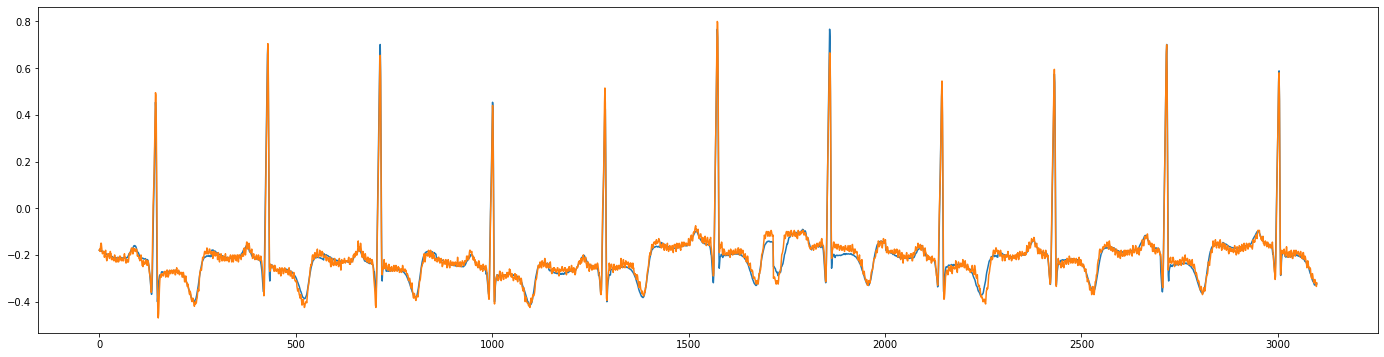

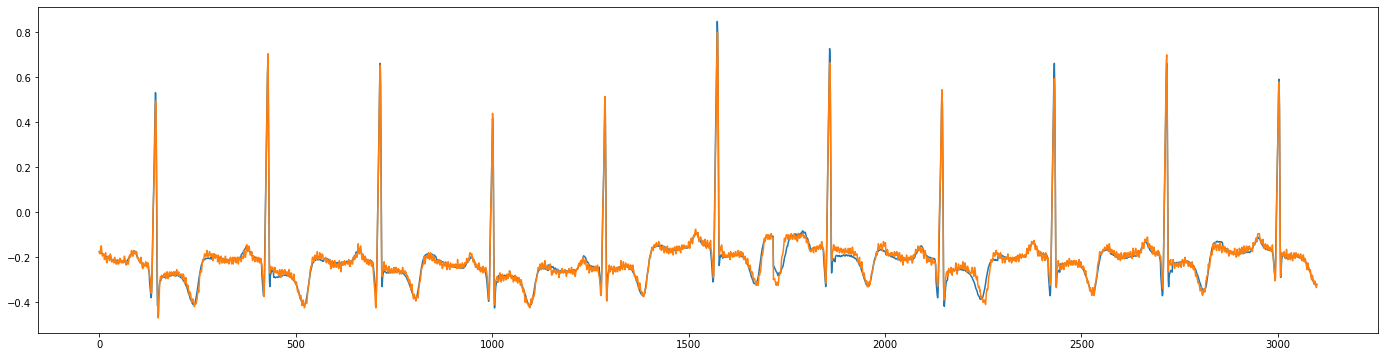

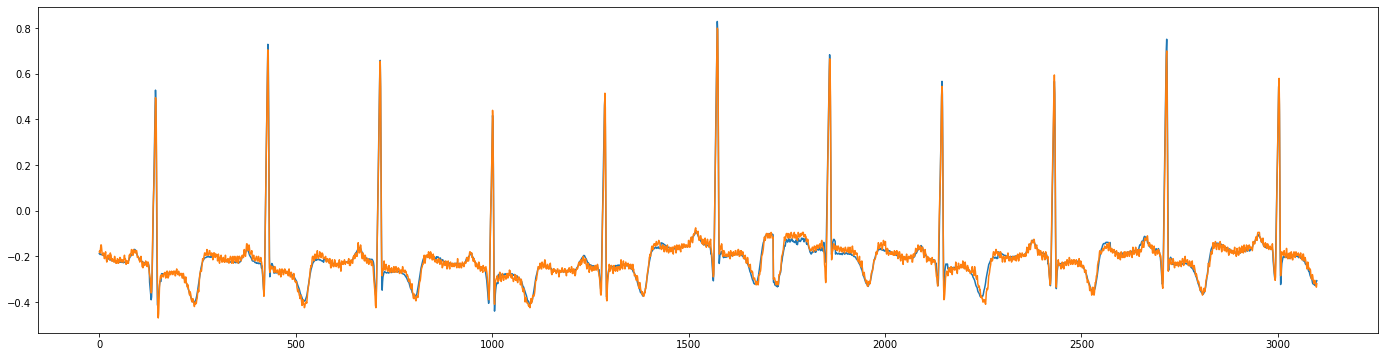

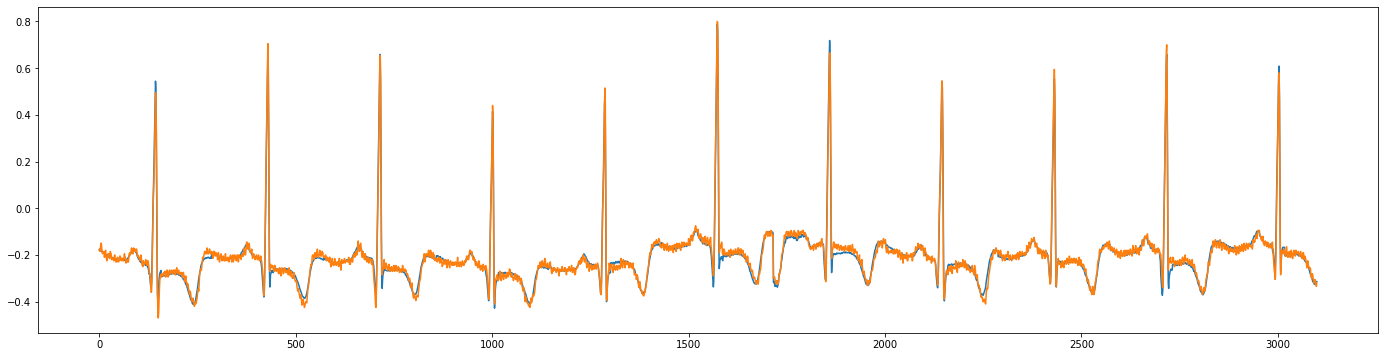

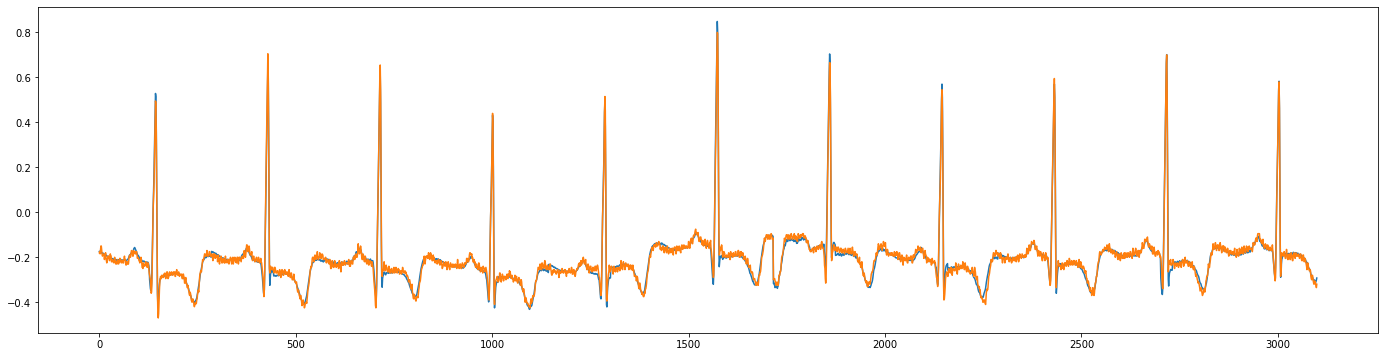

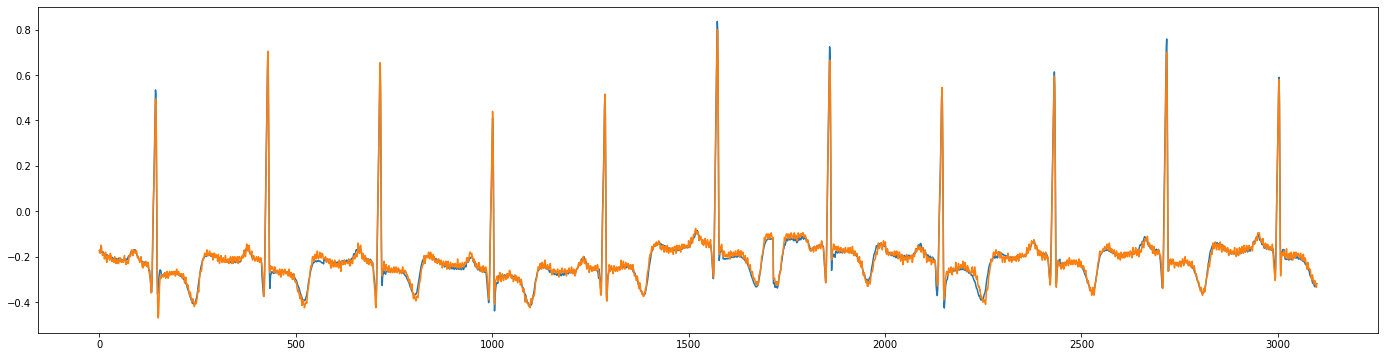

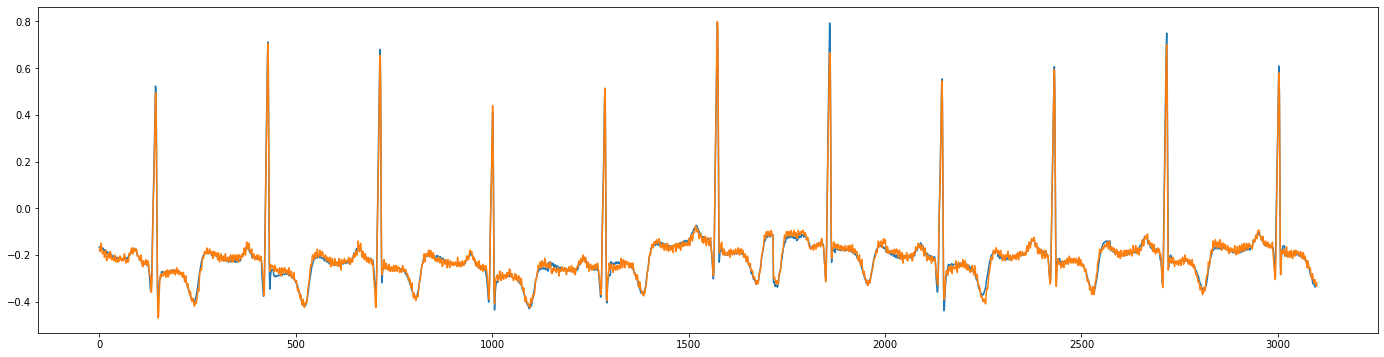

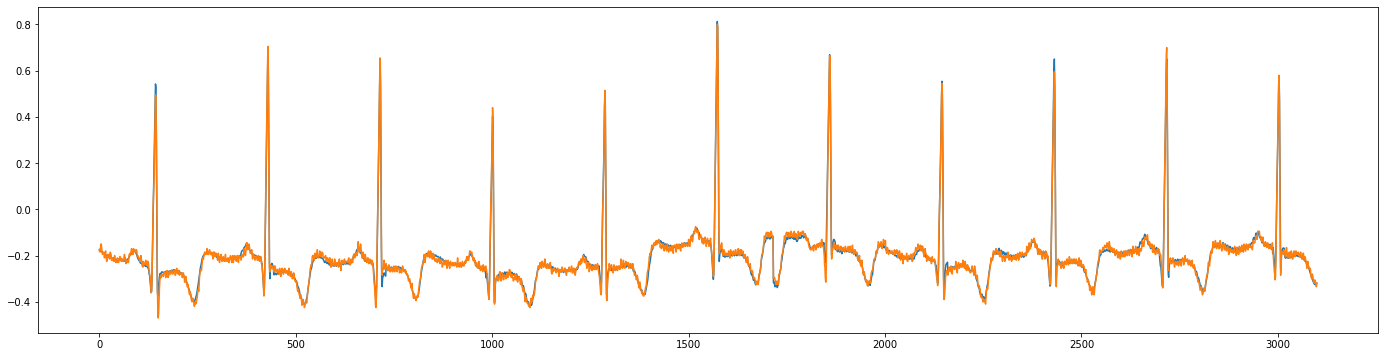

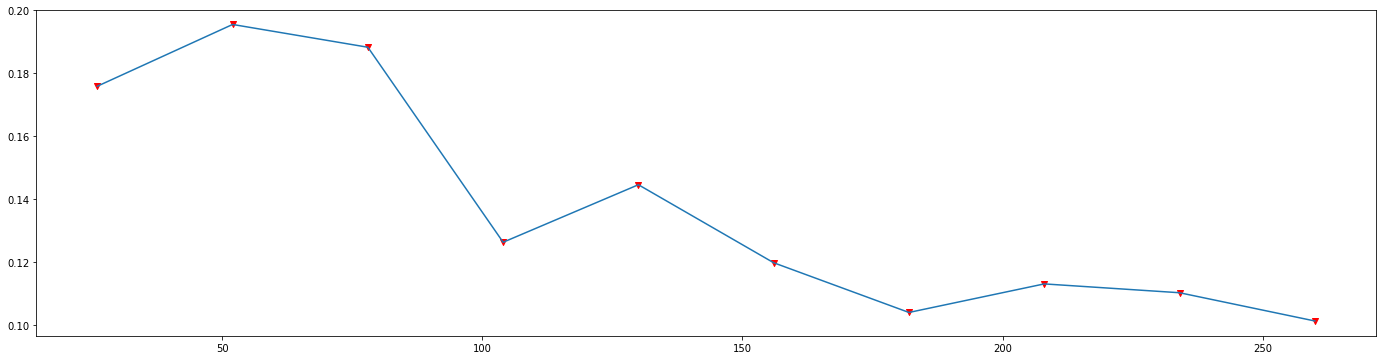

In [47]:
start_test()